In [ ]:
# Activar Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Entrena un modelo de Gradient Boosted Trees
# para predecir el consumo eléctrico
# y la cantidad de usuarios.

# Entrena el modelo final utilizado para el paper.

import pandas as pd
import numpy as np

import xgboost as xgb

from joblib import dump
from joblib import load

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Información

In [ ]:
path_drive = "/content/drive/MyDrive/Colab/Subsidio_electricidad/" 
path_data = path_drive + "data/Actual/data"
path_r = path_drive + "Graficas/"
fname = ".csv"

data_0 = pd.read_csv(path_data + fname)

# Unimos las tarifas 1 y DAC.
data_0["Consumo_1*"] += data_0["Consumo_DAC"]
data_0["Usuarios_1*"] += data_0["Usuarios_DAC"]
data_0.drop( ["Consumo_DAC", "Usuarios_DAC"], axis = 1, inplace = True )

# Escogemos las variables relevantes.
data_0.drop( ["Area", "CVE_MUN", "Tmax", "Tmin", "HDD_mean", "HDD_p10",
    "CDD_p90", "$luz", "Tmean_max_2", "M_verano", #"Tarifa", 
    "Verano"],
    axis = 1, inplace = True)

# Creamos columnas de apoyo.
data_0["Consumo_Usuario"] = data_0["Consumo_1*"] / data_0["Usuarios_1*"]
data_0["Usuario_poblacion"] = data_0["Usuarios_1*"] / data_0["Poblacion"]

# Límites para corrección.
lim = [0.1, 0.6, 30] 

# Estadísticas de corrección.
# Porcentaje de municipios con corrección.
a = data_0.loc[ data_0["Usuario_poblacion"] < lim[0] ].shape[0]
b = data_0.loc[ data_0["Usuario_poblacion"] > lim[1] ].shape[0]
c = data_0.loc[ data_0["Consumo_Usuario"]   < lim[2] ].shape[0]
d = ( a + b + c ) / 12 / 7 / 2469 * 100
print(f"Porcentaje de municipios con corrección: {d:.2f}")
# Porcentaje de población con corrección.
a = data_0.loc[ data_0["Usuario_poblacion"] < lim[0], "Poblacion" ].sum()
b = data_0.loc[ data_0["Usuario_poblacion"] > lim[1], "Poblacion" ].sum()
c = data_0.loc[ data_0["Consumo_Usuario"]   < lim[2], "Poblacion" ].sum()
d = ( a + b + c ) / 12 / 7 / data_0["Poblacion"].sum() * 100
print(f"Porcentaje de población con corrección:  {d:.2f}")
# Porcentaje de consumo con corrección.
a = data_0.loc[ data_0["Usuario_poblacion"] < lim[0], "Consumo_1*" ].sum()
b = data_0.loc[ data_0["Usuario_poblacion"] > lim[1], "Consumo_1*" ].sum()
c = data_0.loc[ data_0["Consumo_Usuario"]   < lim[2], "Consumo_1*" ].sum()
d = ( a + b + c ) / 12 / 7 / data_0["Poblacion"].sum() * 100
print(f"Porcentaje de consumo con corrección:    {d:.2f}")

# Correcciones de municipios que están abajo o arriba de los límites.
data_0.loc[data_0["Usuario_poblacion"] < lim[0], "Usuarios_1*"] = (
    data_0.loc[data_0["Usuario_poblacion"] < lim[0], "Poblacion"] * lim[0] )
data_0.loc[data_0["Usuario_poblacion"] > lim[1], "Usuarios_1*"] = (
    data_0.loc[data_0["Usuario_poblacion"] > lim[1], "Poblacion"] * lim[1] )
data_0.loc[data_0["Consumo_Usuario"] < lim[2], "Consumo_1*"] = (
data_0.loc[data_0["Consumo_Usuario"] < lim[2], "Usuarios_1*"] * 10 )
data_0["Consumo_Usuario"] = data_0["Consumo_1*"] / data_0["Usuarios_1*"]
data_0["Usuario_poblacion"] = data_0["Usuarios_1*"] / data_0["Poblacion"]

# Consumo y usuarios totales en 2010.
cons = data_0[data_0["Año"] == 2010]['Consumo_1*'].sum()
us = data_0[data_0["Año"] == 2010].groupby('CVE_INEGI'
    ).mean()['Usuarios_1*'].sum()

# Información utilizada para el modelo.
data_0.head()

Porcentaje de municipios con corrección: 4.57
Porcentaje de población con corrección:  0.01
Porcentaje de consumo con corrección:    0.13


,CVE_INEGI,CVE_ENT,NOM_ENT,NOM_MUN,Consumo_1*,Usuarios_1*,Tarifa,lon,lat,Tmean,...,Pre_Tmean,Poblacion,PIB,Densidad_poblacion,PCI,$GLP,Año,Mes,Consumo_Usuario,Usuario_poblacion
0,1001,1,Aguascalientes,Aguascalientes,2.297112e+07,235978.0,1,-102.295872,21.8114,14.446821,...,0.000000,797010.0,1.170000e+11,6.833315,146798.659992,10.151,2010,1,97.344329,0.296079
1,1001,1,Aguascalientes,Aguascalientes,2.108122e+07,235978.0,1,-102.295872,21.8114,14.861328,...,0.000000,797010.0,1.170000e+11,6.833315,146798.659992,10.151,2010,2,89.335545,0.296079
2,1001,1,Aguascalientes,Aguascalientes,2.377894e+07,235978.0,1,-102.295872,21.8114,17.526365,...,0.976778,797010.0,1.170000e+11,6.833315,146798.659992,10.151,2010,3,100.767617,0.296079
3,1001,1,Aguascalientes,Aguascalientes,2.591731e+07,235978.0,1,-102.295872,21.8114,19.526386,...,1.510271,797010.0,1.170000e+11,6.833315,146798.659992,10.151,2010,4,109.829363,0.296079
4,1001,1,Aguascalientes,Aguascalientes,2.676120e+07,235978.0,1,-102.295872,21.8114,24.024788,...,10.045719,797010.0,1.170000e+11,6.833315,146798.659992,10.151,2010,5,113.405481,0.296079


In [ ]:
# Estadísticos de las variables.
data_0.describe()

,CVE_INEGI,CVE_ENT,Consumo_1*,Usuarios_1*,lon,lat,Tmean,Pre,CDD_mean,Pre_Tmean,Poblacion,PIB,Densidad_poblacion,PCI,$GLP,Año,Mes,Consumo_Usuario,Usuario_poblacion
count,207396.000000,207396.000000,2.073960e+05,207396.000000,207396.000000,207396.000000,207396.000000,207396.000000,207396.000000,207396.000000,2.073960e+05,2.073960e+05,207396.000000,2.073960e+05,207396.000000,207396.000000,207396.000000,207396.000000,207396.000000
mean,19324.164844,19.215472,1.796605e+06,13453.987404,-98.743039,20.022814,22.416142,92.261068,38.644583,61.727996,4.726342e+04,6.765280e+09,2.879387,8.464168e+04,10.993159,2013.000000,6.500000,90.370874,0.292669
std,7381.414984,7.365866,7.318212e+06,39613.798287,4.384575,3.345745,4.394156,117.350002,47.328752,89.113685,1.360137e+05,2.694244e+10,11.833998,7.166228e+04,0.851131,2.000005,3.452061,53.422585,0.096757
min,1001.000000,1.000000,5.160000e+02,51.600000,-116.889018,14.639368,6.041615,0.000000,0.000000,0.000000,8.600000e+01,2.373494e+06,0.001441,1.273697e+04,8.948300,2010.000000,1.000000,1.915417,0.100000
25%,14079.000000,14.000000,8.545809e+04,1161.000000,-100.737771,17.620009,19.377630,11.312651,3.530260,0.000616,4.273000e+03,2.402809e+08,0.191168,4.303295e+04,10.238682,2011.000000,3.750000,62.369416,0.228530
50%,20226.000000,20.000000,2.677129e+05,3315.000000,-98.236805,19.329310,22.201066,43.194197,20.967391,20.387224,1.301700e+04,8.416350e+08,0.527785,6.653278e+04,11.104057,2013.000000,6.500000,79.695065,0.281833
75%,24027.000000,24.000000,8.346592e+05,8860.000000,-96.769306,20.934726,25.490744,135.280884,58.762242,95.069677,3.362100e+04,2.806882e+09,1.374680,9.753169e+04,11.637004,2015.000000,9.250000,100.693977,0.339522
max,32058.000000,32.000000,2.492331e+08,537946.000000,-86.908934,32.434882,36.112892,1161.472156,374.363434,983.411197,1.830284e+06,4.900000e+11,176.561449,1.234769e+06,13.169542,2016.000000,12.000000,1020.486942,0.600000


In [ ]:
# Matriz de correlación de Pearson.
data_0.corr()

,CVE_INEGI,CVE_ENT,Consumo_1*,Usuarios_1*,lon,lat,Tmean,Pre,CDD_mean,Pre_Tmean,Poblacion,PIB,Densidad_poblacion,PCI,$GLP,Año,Mes,Consumo_Usuario,Usuario_poblacion
CVE_INEGI,1.000000e+00,9.998413e-01,-0.064918,-1.210940e-01,2.369749e-01,-1.816479e-02,0.133952,0.050134,-0.008833,0.062141,-1.299527e-01,-1.309971e-01,-7.796424e-02,-1.489635e-01,1.802796e-02,6.687564e-12,1.001838e-14,0.063193,1.308282e-02
CVE_ENT,9.998413e-01,1.000000e+00,-0.062813,-1.186741e-01,2.332421e-01,-1.038613e-02,0.133269,0.048788,-0.006487,0.061970,-1.275449e-01,-1.289264e-01,-7.679536e-02,-1.436193e-01,1.886758e-02,6.728527e-12,1.000103e-14,0.069039,1.143470e-02
Consumo_1*,-6.491845e-02,-6.281291e-02,1.000000,8.302971e-01,-1.491339e-01,1.933195e-01,0.051082,-0.040451,0.100563,-0.020967,7.938514e-01,7.365749e-01,3.130905e-01,2.760893e-01,5.803049e-03,1.291073e-02,1.080792e-02,0.444668,3.388588e-02
Usuarios_1*,-1.210940e-01,-1.186741e-01,0.830297,1.000000e+00,-1.204414e-01,1.350108e-01,-0.036732,-0.050576,0.038078,-0.027835,9.854493e-01,8.896945e-01,5.418133e-01,3.092807e-01,1.704111e-02,1.858428e-02,-1.280545e-15,0.274426,1.961360e-02
lon,2.369749e-01,2.332421e-01,-0.149134,-1.204414e-01,1.000000e+00,-6.648263e-01,0.283641,0.219681,-0.215081,0.141434,-1.116940e-01,-8.518956e-02,-2.431198e-04,-2.705908e-01,-1.311473e-02,1.913080e-12,3.604851e-15,-0.298023,-2.006195e-01
lat,-1.816479e-02,-1.038613e-02,0.193320,1.350108e-01,-6.648263e-01,1.000000e+00,-0.134246,-0.214621,0.357260,-0.128432,1.210389e-01,1.100495e-01,-2.975554e-02,3.687962e-01,3.705866e-02,1.736863e-12,1.048384e-15,0.539187,1.841587e-01
Tmean,1.339519e-01,1.332685e-01,0.051082,-3.673182e-02,2.836405e-01,-1.342458e-01,1.000000,0.292602,0.536167,0.355719,-5.115129e-02,-3.733268e-02,-1.342712e-01,-1.688623e-03,1.954647e-02,3.653135e-02,3.716337e-02,0.332503,-1.943599e-04
Pre,5.013443e-02,4.878773e-02,-0.040451,-5.057634e-02,2.196809e-01,-2.146209e-01,0.292602,1.000000,0.055692,0.866616,-4.744698e-02,-4.332692e-02,-3.202255e-02,-1.159776e-01,-4.194580e-02,-2.717907e-02,2.215585e-01,-0.043843,-1.340795e-01
CDD_mean,-8.832647e-03,-6.487300e-03,0.100563,3.807822e-02,-2.150812e-01,3.572598e-01,0.536167,0.055692,1.000000,0.233260,3.219185e-02,3.117878e-02,-2.405607e-02,1.241233e-01,2.567613e-03,2.669760e-02,-5.177694e-02,0.363884,7.824006e-02
Pre_Tmean,6.214123e-02,6.197018e-02,-0.020967,-2.783495e-02,1.414337e-01,-1.284320e-01,0.355719,0.866616,0.233260,1.000000,-2.556043e-02,-2.647006e-02,-1.034226e-02,-6.723960e-02,-2.761061e-03,1.401004e-02,1.672546e-01,0.016247,-1.094659e-01


# Usuarios

In [ ]:
# Predicción de usuarios.

# Escogemos el conjunto de features y de variables a predecir.
Y = data_0.iloc[:,5]
X = data_0[ ["Poblacion", "PIB", "PCI", "Año"] ].copy()
X = pd.concat( (X, pd.get_dummies(data_0["CVE_ENT"]) ), axis = 1)

# Separamos en conjuntos de entrenamiento y de prueba.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3)

# Features a utilizar.
X.head()

,Poblacion,PIB,PCI,Año,1,2,3,4,5,6,...,23,24,25,26,27,28,29,30,31,32
0,797010.0,1.170000e+11,146798.659992,2010,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,797010.0,1.170000e+11,146798.659992,2010,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,797010.0,1.170000e+11,146798.659992,2010,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,797010.0,1.170000e+11,146798.659992,2010,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,797010.0,1.170000e+11,146798.659992,2010,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Variable a predecir.
Y.head()

0    235978.0
1    235978.0
2    235978.0
3    235978.0
4    235978.0
Name: Usuarios_1*, dtype: float64

In [ ]:
# Entrenamiento simple.

# Copiamos las variables para poder
# transformarlas en caso de ser necesario.
X_reg = X_train.copy()
Y_reg = Y_train.copy()
X_reg_val = X_val.copy()

# Hiperparámetros.
params = {
    "objective": "reg:squarederror",
    "colsample_bytree": 0.3,
    "learning_rate": 0.1,
    "max_depth": 50,
    "min_child_weight" : 25,
    "min_split_loss": 0.2,
    "n_estimators": 100
    }

# Creamos el regresor con los hiperparámetros.
xg_reg_u = xgb.XGBRegressor( **params )

# Entrenamos el modelo.
xg_reg_u.fit(X_reg, Y_reg, verbose = True)

# Probamos la regresión en el set de entrenamiento.
preds = xg_reg_u.predict(X_reg)

# Calculamos el error de entrenamiento.
rmse_t = np.sqrt(mean_squared_error(Y_reg, preds))
r2_t = r2_score(Y_reg, preds)

print("Entrenamiento")
print(f"RMSE: {rmse_t:.3E}")
print(f"R^2:  {r2_t:.7f}")

Entrenamiento
RMSE: 5.138E+02
R^2:  0.9998331


In [ ]:
# Probamos la regresión en el set de validación.
preds = xg_reg_u.predict(X_reg_val)

# Calculamos el error de validación.
rmse_v = np.sqrt(mean_squared_error(Y_val, preds))
r2_v = r2_score(Y_val, preds)

print("Validación")
print(f"RMSE: {rmse_v:.3E}")
print(f"R^2:  {r2_v:.7f}")

Validación
RMSE: 6.511E+02
R^2:  0.9997247


In [ ]:
# Histograma de los RMSE de validación.

# Cantidad de corridas.
s = 100
trains_X = [None] * s
trains_Y = [None] * s
tests_X  = [None] * s
tests_Y  = [None] * s
preds    = [None] * s 
RMSE     = [None] * s
R2       = [None] * s

# Para cargar el modelo previamente entrenado.
xg_reg_u = load(path_drive + "reg_model_usuarios.joblib")

# Calculamos el RMSE para todas las corridas.
# Separamos en conjuntos de entrenamiento y de prueba.
for i in range( s ):
    # Separamos en conjuntos de entrenamiento y de prueba.
    trains_X[i], tests_X[i], trains_Y[i], tests_Y[i] = train_test_split(
        X, Y, test_size = 0.3)
    # Probamos la regresión en el set de entrenamiento.
    preds[i] = xg_reg_u.predict( tests_X[i] )
    # Calculamos el error de entrenamiento.
    RMSE[i] = np.sqrt( mean_squared_error( tests_Y[i], preds[i] ) )
    R2[i]   = ( r2_score( tests_Y[i], preds[i] ) - 0.999 ) * 10000

RMSE range: 533.3446 to 621.3343
R² range: 7.6033 to 8.1541


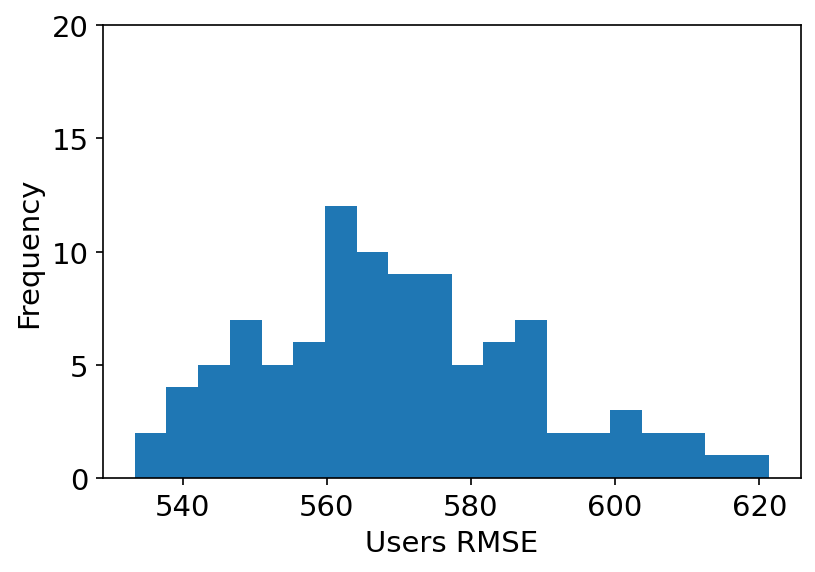

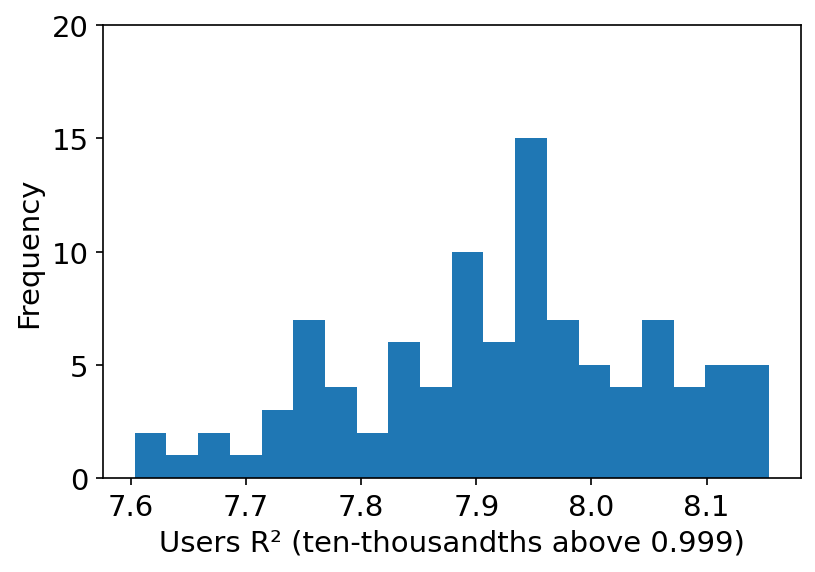

In [ ]:
# Histograma de los RMSE de validación.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )

fig, ax = plt.subplots()
plt.hist( RMSE, bins = 20, density = False );
#plt.plot( (rmse_v, rmse_v), (0, 10), color = "k" )
plt.ylim(0, 20);
plt.xlabel("Users RMSE")
plt.ylabel("Frequency");
plt.savefig( path_r + "RMSE_Users.eps", bbox_inches = "tight" )

fig, ax = plt.subplots()
plt.hist( R2, bins = 20, density = False );
#plt.plot( (r2_v, r2_v), (0, 10), color = "k" )
plt.ylim(0, 20);
plt.xlabel("Users R² (ten-thousandths above 0.999)")
plt.ylabel("Frequency");
plt.savefig( path_r + "R2_Users.eps", bbox_inches = "tight" )

a = np.array(RMSE).min()
b = np.array(RMSE).max()
print(f"RMSE range: {a:.4f} to {b:.4f}")
a = np.array(R2).min()
b = np.array(R2).max()
print(f"R² range: {a:.4f} to {b:.4f}")

# Consumo por usuario

In [ ]:
# Predicción de consumo por usuario.
# Escogemos el conjunto de features y de variables a predecir.
X, Y = data_0.iloc[:,7:-2], data_0.iloc[:,-2]

# Quitamos algunas features.
X.drop( ["Pre", "Año", "Poblacion", "PIB", "lat", "lon"],
    axis = 1, inplace = True )
X = pd.concat( (X, pd.get_dummies(data_0["CVE_ENT"]) ), axis = 1)

# Separamos en conjuntos de entrenamiento y de prueba.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3)

# Features a utilizar.
X.head()

,Tmean,CDD_mean,Pre_Tmean,Densidad_poblacion,PCI,$GLP,Mes,1,2,3,...,23,24,25,26,27,28,29,30,31,32
0,14.446821,0.000000,0.000000,6.833315,146798.659992,10.151,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14.861328,0.000000,0.000000,6.833315,146798.659992,10.151,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17.526365,0.897792,0.976778,6.833315,146798.659992,10.151,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19.526386,4.786536,1.510271,6.833315,146798.659992,10.151,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24.024788,122.205048,10.045719,6.833315,146798.659992,10.151,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Variable a predecir.
Y.head()

0     97.344329
1     89.335545
2    100.767617
3    109.829363
4    113.405481
Name: Consumo_Usuario, dtype: float64

In [ ]:
# Entrenamiento simple.

# Copiamos las variables para poder
# transformarlas en caso de ser necesario.
X_reg = X_train.copy()
Y_reg = Y_train.copy()
X_reg_val = X_val.copy()

# Hiperparámetros.
params = {
    "objective": "reg:squarederror",
    "colsample_bytree": 0.3,
    "learning_rate": 0.1,
    "max_depth": 50,
    "min_child_weight" : 25,
    "min_split_loss": 0.2,
    "n_estimators": 100
    }

# Creamos el regresor con los hiperparámetros.
xg_reg = xgb.XGBRegressor( **params )

# Entrenamos el modelo.
xg_reg.fit(X_reg, Y_reg, verbose = True)

# Probamos la regresión en el set de entrenamiento.
preds = xg_reg.predict(X_reg)

# Calculamos el error de entrenamiento.
rmse_t = np.sqrt(mean_squared_error(Y_reg, preds))
r2_t = r2_score(Y_reg, preds)

print("Entrenamiento")
print(f"RMSE: {rmse_t:.3E}")
print(f"R^2:  {r2_t:.7f}")

Entrenamiento
RMSE: 6.867E+00
R^2:  0.9834424


In [ ]:
# Probamos la regresión en el set de validación.
preds = xg_reg.predict(X_reg_val)

# Calculamos el error de validación.
rmse_v = np.sqrt(mean_squared_error(Y_val, preds))
r2_v = r2_score(Y_val, preds)

print("Validación")
print(f"RMSE: {rmse_v:.3E}")
print(f"R^2:  {r2_v:.7f}")

Validación
RMSE: 1.274E+01
R^2:  0.9433714


In [ ]:
# Histograma de los RMSE de validación.

# Cantidad de corridas.
s = 100
trains_X = [None] * s
trains_Y = [None] * s
tests_X  = [None] * s
tests_Y  = [None] * s
preds    = [None] * s 
RMSE     = [None] * s
R2       = [None] * s

# Para cargar el modelo previamente entrenado.
xg_reg = load(path_drive + "reg_model_consumo.joblib")

# Calculamos el RMSE para todas las corridas.
# Separamos en conjuntos de entrenamiento y de prueba.
for i in range( s ):
    # Separamos en conjuntos de entrenamiento y de prueba.
    trains_X[i], tests_X[i], trains_Y[i], tests_Y[i] = train_test_split(
        X, Y, test_size = 0.3)
    # Probamos la regresión en el set de entrenamiento.
    preds[i] = xg_reg.predict( tests_X[i] )
    # Calculamos el error de entrenamiento.
    RMSE[i] = np.sqrt( mean_squared_error( tests_Y[i], preds[i] ) )
    R2[i]   = ( r2_score( tests_Y[i], preds[i] ) - 0.95 ) * 1000

RMSE range: 10.8767 to 11.8155
R² range: 1.0156 to 7.5185


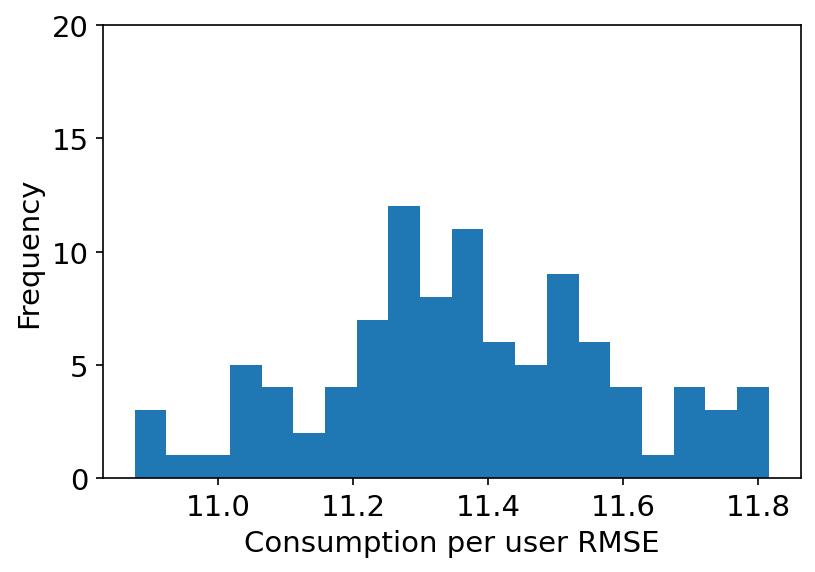

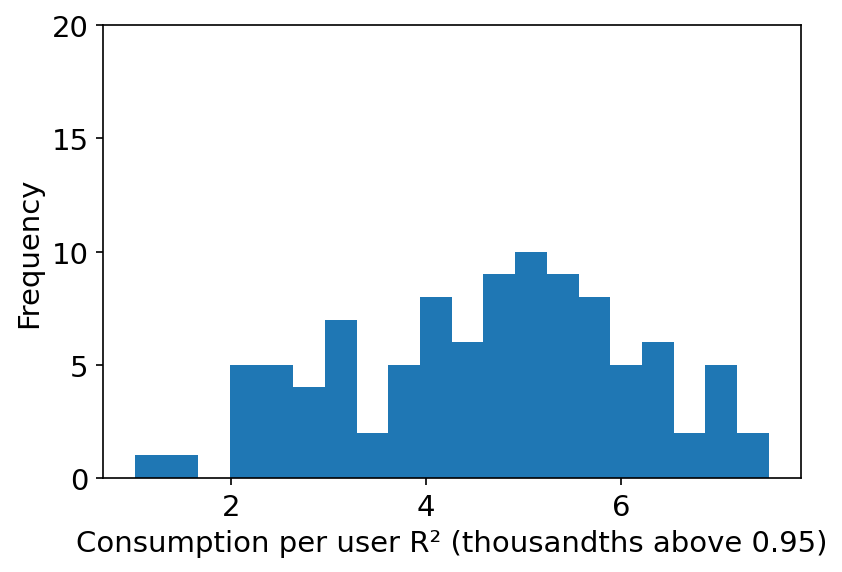

In [ ]:
# Histograma de los RMSE de entrenamiento.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )

fig, ax = plt.subplots()
plt.hist( RMSE, bins = 20, density = False );
#plt.plot( (rmse_v, rmse_v), (0, 10), color = "k" )
plt.ylim(0, 20);
plt.xlabel("Consumption per user RMSE")
plt.ylabel("Frequency");
plt.savefig( path_r + "RMSE_Consumption.eps", bbox_inches = "tight" )

fig, ax = plt.subplots()
plt.hist( R2, bins = 20, density = False );
#plt.plot( (r2_v, r2_v), (0, 10), color = "k" )
plt.ylim(0, 20);
plt.xlabel("Consumption per user R² (thousandths above 0.95)")
plt.ylabel("Frequency");
plt.savefig( path_r + "R2_Consumption.eps", bbox_inches = "tight" )

a = np.array(RMSE).min()
b = np.array(RMSE).max()
print(f"RMSE range: {a:.4f} to {b:.4f}")
a = np.array(R2).min()
b = np.array(R2).max()
print(f"R² range: {a:.4f} to {b:.4f}")

# Predicción

In [ ]:
# Datos.
fname = "data.csv"

# Cargamos los modelos.
xg_reg   = load( path_drive + "reg_model_consumo.joblib"  )
xg_reg_u = load( path_drive + "reg_model_usuarios.joblib" )

# Escenarios
RCP = ["RCP4p5", "RCP8p5"]
fut = [2030, 2050, 2070]
csv = ".csv"

In [ ]:
# RCP8.5

# Directorios.
path_data = [path_drive + "data/" + x + "/data." for x in [RCP[1]] ]
f_path = []
for p in path_data:
    f_path = ( f_path + [p + str(x) + csv for x in fut]
        + [p + str(x) + "_tarifa_teorica" + csv for x in fut]
        + [p + str(x) + "_pob_pib" + csv for x in fut] )

reg_model_pred = [ xg_reg, xg_reg_u ]

# Iteramos para todos los escenarios.
for i in f_path:
    data = pd.read_csv(i)

    if   i == f_path[6]: data["Año"] = 2030
    elif i == f_path[7]: data["Año"] = 2050
    elif i == f_path[8]: data["Año"] = 2070

    # Escogemos el conjunto de features para
    # la predicción de consumo por usuario.
    X = data[ ["Tmean", "CDD_mean", "Pre_Tmean",
        "Densidad_poblacion", "PCI", "$GLP", "Mes"] ].copy()
    X = pd.concat( (X, pd.get_dummies(data["CVE_ENT"]) ), axis = 1)

    # Escogemos el conjunto de features para la predicción de usuarios.
    X_u = data[ ["Poblacion", "PIB", "PCI", "Año"] ].copy()
    X_u = pd.concat( (X_u, pd.get_dummies(data["CVE_ENT"]) ), axis = 1)
    
    # Hacemos la predicción y calculamos el consumo total.
    data["Consumo_Usuario"] = reg_model_pred[0].predict(X)
    data["Usuarios_1*"] = reg_model_pred[1].predict(X_u)
    data["Consumo_1*"] = data["Usuarios_1*"] * data["Consumo_Usuario"]
    data["Usuario_poblacion"] = data["Usuarios_1*"] / data["Poblacion"]
    
    # Nombre de la corrida.
    print(f"Corrida: {i[68:-4]}")
    # Límites para corrección.
    lim = [0.11, 1.6, 30] 

    # Estadísticas de corrección.
    # Porcentaje de municipios abajo o arriba del umbral.
    a = ( ( data[ data["Usuario_poblacion"] < lim[0] ].shape[0]
        +   data[ data["Usuario_poblacion"] > lim[1] ]["Poblacion"].shape[0] )
        / 12 / 2649 * 100 )
    print(f"Porcentaje de municipios abajo o arriba del umbral:     {a:05.2f}")
    # Porcentaje de la población abajo o arriba del umbral.
    a = ( ( data.loc[ data["Usuario_poblacion"] < lim[0], "Poblacion"].sum()
        +   data.loc[ data["Usuario_poblacion"] > lim[1], "Poblacion"].sum() )
        / data["Poblacion"].sum() * 100 )
    print(f"Porcentaje de la población abajo o arriba del umbral:    {a:.2f}")
    # Porcentaje del consumo abajo o arriba del umbral.
    a = ( ( data_0.where( data["Usuario_poblacion"] > lim[1] ).dropna()
        .groupby('CVE_INEGI').mean()["Consumo_1*"].sum() + 
        ( data_0.where( data["Usuario_poblacion"] < lim[0] ).dropna()
        .groupby('CVE_INEGI').mean()["Consumo_1*"].sum() ) ) * 100 / cons )
    print(f"Porcentaje del consumo abajo o arriba del umbral:        {a:.2f}")
    # Porcentaje del consumo arriba del umbral.
    a = data[ data["Usuario_poblacion"] > lim[1] ]
    a = ( ( ( a["Usuario_poblacion"] - lim[1] ) * a["Consumo_Usuario"]
        * a["Poblacion"] ).sum() / data["Consumo_1*"].sum() * 100 )
    print(f"Porcentaje del consumo arriba del umbral:                {a:.2f}")
    # Porcentaje de municipios que tuvieron consumo negativo.
    #a = data[ data["Usuarios_1*"] < 0 ].shape[0] * 100 / 12 / 2469
    #print(f"Porcentaje de municipios que tuvieron consumo negativo:  {a:.2f}")
    # Porcentaje de población que tuvo consumo negativo.
    #a = ( data.loc[ data["Usuarios_1*"] < 0, "Poblacion"].sum()
    #    / data["Poblacion"].sum() * 100 )
    #print(f"Porcentaje de población que tuvo consumo negativo:       {a:.2f}")
    # Porcentaje de municipios abajo del umbral de Consumo_Usuario.
    a = data[ data["Consumo_Usuario"] < lim[2] ].shape[0] / 12 / 2469 * 100 
    print(f"Porcentaje de municipios abajo del umbral de consumo:    {a:.2f}")

    # Correcciones de municipios que están abajo o arriba de los límites.
    data.loc[ data["Usuario_poblacion"] < lim[0], "Usuarios_1*" ] = (
        data.loc[ data["Usuario_poblacion"] < lim[0], "Poblacion" ] * lim[0] )
    data.loc[ data["Usuario_poblacion"] > lim[1], "Usuarios_1*" ] = (
        data.loc[ data["Usuario_poblacion"] > lim[1], "Poblacion" ] * lim[1] )
    data["Consumo_1*"] = data["Usuarios_1*"] * data["Consumo_Usuario"]
    data.loc[ data["Consumo_Usuario"]   < lim[2], "Consumo_1*" ] = (
        data.loc[ data["Consumo_Usuario"]   < lim[2], "Usuarios_1*" ] * 10 )

    # Retiramos las columnas de apoyo.
    data.drop( columns = ["Consumo_Usuario", "Usuario_poblacion"],
        inplace = True )

    # Incremento en consumo con respecto a 2010.
    perc = ( data['Consumo_1*'].sum() / cons - 1 ) * 100
    print(f"Consumo:  {data['Consumo_1*'].sum():+.2e}, {perc:06.2f}%")
    # Incremento en usuarios con respecto a 2010.
    a = data.groupby('CVE_INEGI').mean()['Usuarios_1*'].sum()
    perc = ( a / us - 1 ) * 100
    print(f"Usuarios: {a:+.2e}, {perc:06.2f}% \n")
    
    # Guardamos el archivo.
    #data.to_csv(i, index = False)

Corrida: 2030
Porcentaje de municipios abajo o arriba del umbral:     09.10
Porcentaje de la población abajo o arriba del umbral:    1.14
Porcentaje del consumo abajo o arriba del umbral:        1.27
Porcentaje del consumo arriba del umbral:                3.10
Porcentaje de municipios abajo del umbral de consumo:    0.01
Consumo:  +7.66e+10, 057.22%
Usuarios: +4.60e+07, 050.32% 

Corrida: 2050
Porcentaje de municipios abajo o arriba del umbral:     24.69
Porcentaje de la población abajo o arriba del umbral:    3.83
Porcentaje del consumo abajo o arriba del umbral:        1.84
Porcentaje del consumo arriba del umbral:                10.07
Porcentaje de municipios abajo del umbral de consumo:    0.00
Consumo:  +1.10e+11, 125.60%
Usuarios: +5.74e+07, 087.30% 

Corrida: 2070
Porcentaje de municipios abajo o arriba del umbral:     32.73
Porcentaje de la población abajo o arriba del umbral:    5.61
Porcentaje del consumo abajo o arriba del umbral:        2.19
Porcentaje del consumo arriba d

In [ ]:
# RCP4.5

# Directorios.
path_data = [path_drive + "data/" + x + "/data." for x in [RCP[0]] ]
f_path = []
for p in path_data:
    f_path = ( f_path + [p + str(x) + csv for x in fut]
        + [p + str(x) + "_tarifa_teorica" + csv for x in fut]
        + [p + str(x) + "_pob_pib" + csv for x in fut] )

reg_model_pred = [ xg_reg, xg_reg_u ]

# Iteramos para todos los escenarios.
for i in f_path:
    data = pd.read_csv(i)

    if   i == f_path[6]: data["Año"] = 2030
    elif i == f_path[7]: data["Año"] = 2050
    elif i == f_path[8]: data["Año"] = 2070

    # Escogemos el conjunto de features para
    # la predicción de consumo por usuario.
    X = data[ ["Tmean", "CDD_mean", "Pre_Tmean",
        "Densidad_poblacion", "PCI", "$GLP", "Mes"] ].copy()
    X = pd.concat( (X, pd.get_dummies(data["CVE_ENT"]) ), axis = 1)

    # Escogemos el conjunto de features para la predicción de usuarios.
    X_u = data[ ["Poblacion", "PIB", "PCI", "Año"] ].copy()
    X_u = pd.concat( (X_u, pd.get_dummies(data["CVE_ENT"]) ), axis = 1)
    
    # Hacemos la predicción y calculamos el consumo total.
    data["Consumo_Usuario"] = reg_model_pred[0].predict(X)
    data["Usuarios_1*"] = reg_model_pred[1].predict(X_u)
    data["Consumo_1*"] = data["Usuarios_1*"] * data["Consumo_Usuario"]
    data["Usuario_poblacion"] = data["Usuarios_1*"] / data["Poblacion"]
    
    # Nombre de la corrida.
    print(f"Corrida: {i[68:-4]}")
    # Límites para corrección.
    lim = [0.11, 1.6, 30] 

    # Estadísticas de corrección.
    # Porcentaje de municipios abajo o arriba del umbral.
    a = ( ( data[ data["Usuario_poblacion"] < lim[0] ].shape[0]
        +   data[ data["Usuario_poblacion"] > lim[1] ]["Poblacion"].shape[0] )
        / 12 / 2649 * 100 )
    print(f"Porcentaje de municipios abajo o arriba del umbral:     {a:05.2f}")
    # Porcentaje de la población abajo o arriba del umbral.
    a = ( ( data.loc[ data["Usuario_poblacion"] < lim[0], "Poblacion"].sum()
        +   data.loc[ data["Usuario_poblacion"] > lim[1], "Poblacion"].sum() )
        / data["Poblacion"].sum() * 100 )
    print(f"Porcentaje de la población abajo o arriba del umbral:    {a:.2f}")
    # Porcentaje del consumo abajo o arriba del umbral.
    a = ( ( data_0.where( data["Usuario_poblacion"] > lim[1] ).dropna()
        .groupby('CVE_INEGI').mean()["Consumo_1*"].sum() + 
        ( data_0.where( data["Usuario_poblacion"] < lim[0] ).dropna()
        .groupby('CVE_INEGI').mean()["Consumo_1*"].sum() ) ) * 100 / cons )
    print(f"Porcentaje del consumo abajo o arriba del umbral:        {a:.2f}")
    # Porcentaje del consumo arriba del umbral.
    a = data[ data["Usuario_poblacion"] > lim[1] ]
    a = ( ( ( a["Usuario_poblacion"] - lim[1] ) * a["Consumo_Usuario"]
        * a["Poblacion"] ).sum() / data["Consumo_1*"].sum() * 100 )
    print(f"Porcentaje del consumo arriba del umbral:                {a:.2f}")
    # Porcentaje de municipios que tuvieron consumo negativo.
    #a = data[ data["Usuarios_1*"] < 0 ].shape[0] * 100 / 12 / 2469
    #print(f"Porcentaje de municipios que tuvieron consumo negativo:  {a:.2f}")
    # Porcentaje de población que tuvo consumo negativo.
    #a = ( data.loc[ data["Usuarios_1*"] < 0, "Poblacion"].sum()
    #    / data["Poblacion"].sum() * 100 )
    #print(f"Porcentaje de población que tuvo consumo negativo:       {a:.2f}")
    # Porcentaje de municipios abajo del umbral de Consumo_Usuario.
    a = data[ data["Consumo_Usuario"] < lim[2] ].shape[0] / 12 / 2469 * 100 
    print(f"Porcentaje de municipios abajo del umbral de consumo:    {a:.2f}")

    # Correcciones de municipios que están abajo o arriba de los límites.
    data.loc[ data["Usuario_poblacion"] < lim[0], "Usuarios_1*" ] = (
        data.loc[ data["Usuario_poblacion"] < lim[0], "Poblacion" ] * lim[0] )
    data.loc[ data["Usuario_poblacion"] > lim[1], "Usuarios_1*" ] = (
        data.loc[ data["Usuario_poblacion"] > lim[1], "Poblacion" ] * lim[1] )
    data["Consumo_1*"] = data["Usuarios_1*"] * data["Consumo_Usuario"]
    data.loc[ data["Consumo_Usuario"]   < lim[2], "Consumo_1*" ] = (
        data.loc[ data["Consumo_Usuario"]   < lim[2], "Usuarios_1*" ] * 10 )

    # Retiramos las columnas de apoyo.
    data.drop( columns = ["Consumo_Usuario", "Usuario_poblacion"],
        inplace = True )

    # Incremento en consumo con respecto a 2010.
    perc = ( data['Consumo_1*'].sum() / cons - 1 ) * 100
    print(f"Consumo:  {data['Consumo_1*'].sum():+.2e}, {perc:06.2f}%")
    # Incremento en usuarios con respecto a 2010.
    a = data.groupby('CVE_INEGI').mean()['Usuarios_1*'].sum()
    perc = ( a / us - 1 ) * 100
    print(f"Usuarios: {a:+.2e}, {perc:06.2f}% \n")
    
    # Guardamos el archivo.
    data.to_csv(i, index = False)

Corrida: 2030
Porcentaje de municipios abajo o arriba del umbral:     06.23
Porcentaje de la población abajo o arriba del umbral:    0.70
Porcentaje del consumo abajo o arriba del umbral:        1.09
Porcentaje del consumo arriba del umbral:                1.76
Porcentaje de municipios abajo del umbral de consumo:    0.00
Consumo:  +7.30e+10, 049.89%
Usuarios: +4.54e+07, 048.08% 

Corrida: 2050
Porcentaje de municipios abajo o arriba del umbral:     14.04
Porcentaje de la población abajo o arriba del umbral:    2.10
Porcentaje del consumo abajo o arriba del umbral:        1.50
Porcentaje del consumo arriba del umbral:                4.82
Porcentaje de municipios abajo del umbral de consumo:    0.00
Consumo:  +9.99e+10, 105.12%
Usuarios: +5.78e+07, 088.82% 

Corrida: 2070
Porcentaje de municipios abajo o arriba del umbral:     22.01
Porcentaje de la población abajo o arriba del umbral:    3.19
Porcentaje del consumo abajo o arriba del umbral:        1.94
Porcentaje del consumo arriba de